In [7]:
import cv2
import os
import numpy as np
import tensorflow as tf

# Path to preprocessed data
frames_dir = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\training\frames'
masks_dir = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\training\lane-masks'

# Define a batch generator
def data_generator(frames_dir, masks_dir, batch_size=32, img_size=(128, 128)):
    image_files = os.listdir(frames_dir)
    mask_files = os.listdir(masks_dir)
    
    while True:
        # Shuffle the files at the beginning of each epoch
        indices = np.random.permutation(len(image_files))
        
        for start in range(0, len(image_files), batch_size):
            end = min(start + batch_size, len(image_files))
            batch_indices = indices[start:end]

            # Initialize batches
            batch_images = []
            batch_masks = []
            
            for i in batch_indices:
                img_path = os.path.join(frames_dir, image_files[i])
                mask_path = os.path.join(masks_dir, mask_files[i])
                
                # Read the image and the corresponding mask
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Mask is single channel

                # Resize images and masks to the desired size
                img_resized = cv2.resize(img, img_size) / 255.0  # Normalize to [0, 1]
                mask_resized = cv2.resize(mask, img_size) / 255.0  # Normalize to [0, 1]

                batch_images.append(img_resized)
                batch_masks.append(mask_resized)

            # Convert batches to numpy arrays
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            yield batch_images, batch_masks  # Yield the batch for training

# Example usage of the data generator
batch_size = 32
train_gen = data_generator(frames_dir, masks_dir, batch_size=batch_size)

# To test, let's check the shape of the first batch
x_batch, y_batch = next(train_gen)
print(f"Batch of images shape: {x_batch.shape}")
print(f"Batch of masks shape: {y_batch.shape}")


Batch of images shape: (32, 128, 128, 3)
Batch of masks shape: (32, 128, 128)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(128, 128, 3)):
    # Input layer
    inputs = layers.Input(input_size)

    # Contracting path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Define the model
    model = models.Model(inputs, outputs)

    return model


Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9409 - loss: 0.2246
Epoch 1: val_loss improved from inf to 0.10134, saving model to best_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 2539s 11s/step - accuracy: 0.9409 - loss: 0.2243 - val_accuracy: 0.9463 - val_loss: 0.1013
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9464 - loss: 0.0912
Epoch 2: val_loss improved from 0.10134 to 0.07030, saving model to best_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 2698s 12s/step - accuracy: 0.9464 - loss: 0.0912 - val_accuracy: 0.9498 - val_loss: 0.0703
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9516 - loss: 0.0671
Epoch 3: val_loss improved from 0.07030 to 0.05916, saving model to best_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 2691s 12s/step - accuracy: 0.9516 - loss: 0.0671 - val_accuracy: 0.9540 - val_loss: 0.0592
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9545 - loss: 0.0573
Epoch 4: val_loss improved from 0.05916 to 0.0515

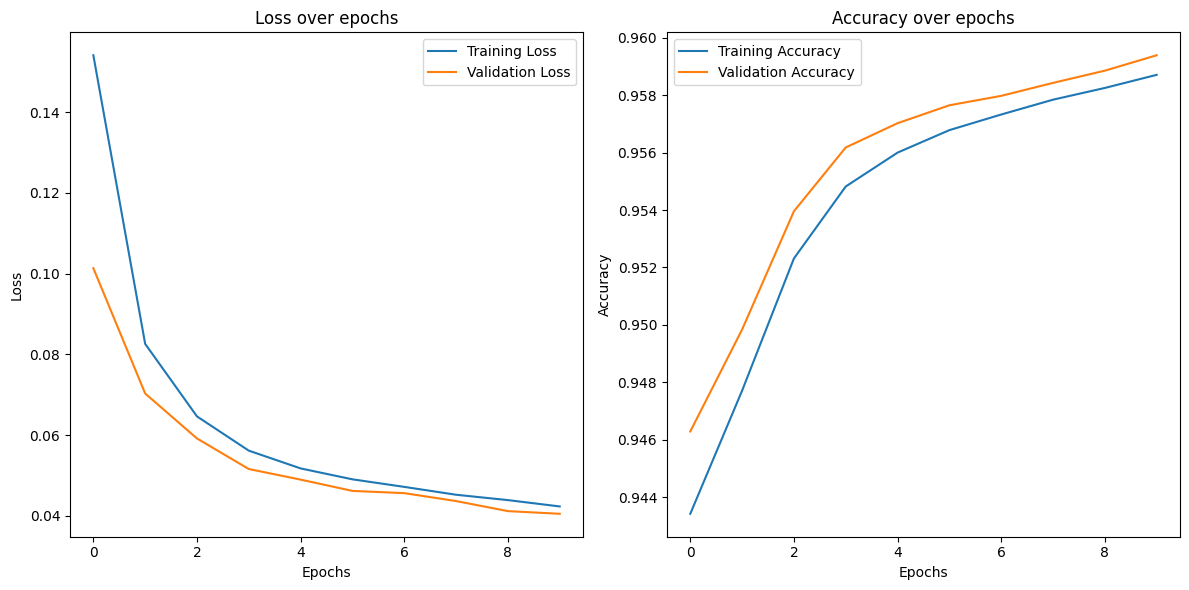

In [9]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Define the U-Net model (assuming you have the function 'unet_model' defined elsewhere)
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the batch size
batch_size = 16  # Reduced batch size

# Define the training data generator
train_gen = data_generator(frames_dir, masks_dir, batch_size=batch_size)

# Optionally, define the validation data generator (if validation data is available)
val_gen = data_generator(frames_dir, masks_dir, batch_size=batch_size)

# Define the ModelCheckpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  # File path to save the best model (now ending with .keras)
    monitor='val_loss',  # Metric to monitor (can also use 'val_accuracy')
    mode='min',  # 'min' for loss, 'max' for accuracy
    save_best_only=True,  # Save only the best model
    verbose=1  # Print a message when the model is saved
)

# Train the model with the callback
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(os.listdir(frames_dir)) // batch_size,
    validation_steps=len(os.listdir(masks_dir)) // batch_size,
    epochs=10,
    callbacks=[checkpoint_callback]  # Include the checkpoint callback
)

# Plot training & validation loss and accuracy
def plot_training_history(history):
    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history after training
plot_training_history(history)

# Optionally, you can load the best model (after training is complete)
best_model = load_model(r'C:\Users\adidi\Downloads\ENet\best_model.keras')


In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the best saved model
model = tf.keras.models.load_model(r'C:\Users\adidi\Downloads\ENet\best_model.keras', compile=False)


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import json

# Path to the JSON file for the test set
test_annotations_path = r'C:\Users\adidi\Downloads\ENet\TUSimple\test_set\test_label.json'

# Paths to save the generated masks and frames
test_mask_path = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\test\lane-masks'
test_frame_path = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\test\frames'

# Ensure the directories exist
os.makedirs(test_mask_path, exist_ok=True)
os.makedirs(test_frame_path, exist_ok=True)

def generate_lane_mask(row, training_set=True):
    '''
        Generates and writes the corresponding lane masks for the given images.
    '''
    # Create a mask of all zeros (720x1280, which is the resolution for TUSimple dataset)
    mask = np.zeros((720, 1280, 3), dtype=np.uint8)  # Ensuring proper dtype for mask
    h_samples = row['h_samples']  # Horizontal sample positions
    lanes = row['lanes']  # Lane markings
    raw_file = row['raw_file']  # Raw file path

    # Create mask: lane: 1, non-lane: 0
    for lane in lanes:
        # -2 indicates no line in the specified point, so we omit these points
        h_samples_updated = [y for x, y in zip(lane, h_samples) if x != -2]
        lane = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane, h_samples_updated)))

        # Add lane markings to the mask we created (white line for lane)
        cv2.polylines(mask, [lane_points], False, (255, 255, 255), thickness=15)

    # Define the path where lane masks will be stored
    path = test_mask_path if not training_set else r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\training\lane-masks'
    
    # Name each mask according to its image's name
    tmp = raw_file[:-7].split('/')[-2:]
    mask_fname = f'{tmp[0]}_{tmp[1]}.jpg'
    new_file = os.path.join(path, mask_fname)
    
    # Save the mask image
    cv2.imwrite(new_file, mask)

    return mask_fname

# Process the test set JSON file
data = []

with open(test_annotations_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Convert JSON data to DataFrame for easier processing
df = pd.DataFrame(data)

# Loop through each row in the DataFrame to generate lane masks and save frames
for index, row in df.iterrows():
    # Generate the lane mask for the current frame
    mask_fname = generate_lane_mask(row, training_set=False)
    
    # Save the corresponding frame
    raw_file = row['raw_file']
    frame_path = os.path.join(r'C:\Users\adidi\Downloads\ENet\TUSimple\test_set', raw_file.replace('/', os.sep))
    frame = cv2.imread(frame_path)
    if frame is not None:
        frame_fname = os.path.join(test_frame_path, mask_fname)
        cv2.imwrite(frame_fname, frame)
    else:
        print(f"Frame not found: {frame_path}")

    # Print progress every 200 rows
    if index % 200 == 0:
        print(f"Processed Row: {index} from test JSON")

print("Test lane masks and frames generated successfully!")


Processed Row: 0 from test JSON
Processed Row: 200 from test JSON
Processed Row: 400 from test JSON
Processed Row: 600 from test JSON
Processed Row: 800 from test JSON
Processed Row: 1000 from test JSON
Processed Row: 1200 from test JSON
Processed Row: 1400 from test JSON
Processed Row: 1600 from test JSON
Processed Row: 1800 from test JSON
Processed Row: 2000 from test JSON
Processed Row: 2200 from test JSON
Processed Row: 2400 from test JSON
Processed Row: 2600 from test JSON
Test lane masks and frames generated successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


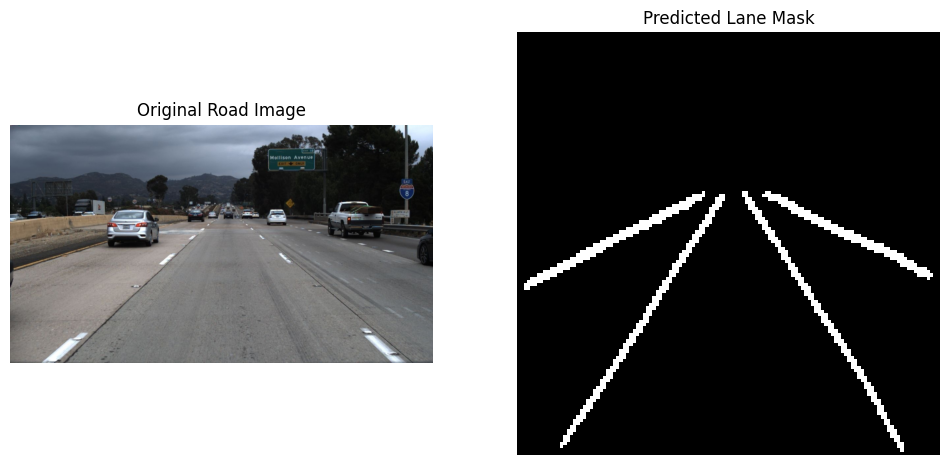

In [3]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Path to the trained model
model_path = r'C:\Users\adidi\Downloads\ENet\best_model.keras'  # Change this to your model path
model = load_model(model_path)

# Function to load and preprocess the input image
def preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image: {image_path}")
        return None
    
    # Resize image to the expected input size and normalize it to [0, 1]
    image_resized = cv2.resize(image, img_size) / 255.0
    return image_resized

# Function to predict lane mask for a given image
def predict_lane_mask(model, image_path, img_size=(128, 128)):
    # Preprocess the input image
    img_resized = preprocess_image(image_path, img_size)
    
    if img_resized is None:
        return None
    
    # Add batch dimension (model expects batch of images)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Make prediction using the trained model
    prediction = model.predict(img_input)[0]  # Get the prediction (remove batch dimension)
    
    # Post-process the prediction (e.g., thresholding for binary segmentation)
    prediction = (prediction > 0.5).astype(np.uint8)  # Convert to binary mask (0 or 1)
    
    return prediction

# Function to display the input image and the predicted lane mask
def display_prediction(image_path, prediction):
    # Load original image to show
    image = cv2.imread(image_path)
    
    # Display the original image and the predicted mask
    plt.figure(figsize=(12, 6))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Road Image")
    plt.axis('off')
    
    # Show predicted lane mask
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title("Predicted Lane Mask")
    plt.axis('off')
    
    plt.show()

# Path to the road image you want to predict lane mask for
image_path = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\test\frames\0601_1494453475619239031.jpg'  # Replace with your image path

# Get prediction for lane mask
prediction = predict_lane_mask(model, image_path)

# If prediction is successful, display the result
if prediction is not None:
    display_prediction(image_path, prediction)
